# Calculating the delta of a digital option

Consider a **digital option** which pays 1 euro if the stock price at expiry is higher than thestrike and otherwise nothing. 

Since the payoff is not continues we have two options to calculate delta:

- Use the **Likelihood Ratio Method**
- Use the **Pathwise Method** after transforming the payoffs to ensure continuity (Using the CDF of a nromla distribution as a smoothing function)

## Likelihood ratio method

$$ \delta = e^{-rT} 1_{S_{t} > K} \frac{Z}{S_{o}\sigma \sqrt{T}} $$


In [1]:
import numpy as np
from numba import njit
from numba import jit
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Parameters
T = 1
K = 99
S0 = 100
r = 0.06
sigma = 0.2

In [3]:
def digital_option(S0, K ,r ,sigma ,T ,n_iter):
    mc_payoffs = []
    for i in range(n_iter):
        # Calculating the Stock price at T
        phi = np.random.standard_normal()
        ST = S0 * np.exp((r - 0.5 * sigma ** 2 ) * T + sigma * np.sqrt(T) * phi)

        # Check if digital option pays off
        if ST-K > 0:
            mc_payoffs.append( 1 * np.exp(-r)) # Present value of 1 euro
        else:
            mc_payoffs.append(0) # or present value of nothing

    # Returns a series of simulated prsent value digital option payoffs
    return mc_payoffs

In [5]:
@njit
def digital_delta_likelihood(S0, K ,r ,sigma ,T ,n_iter):
    deltas = []
    for i in range(n_iter):
        # Calculating the Stock price at T
        phi = np.random.standard_normal()
        ST = S0 * np.exp((r - 0.5 * sigma ** 2 ) * T + sigma * np.sqrt(T) * phi)

        if ST > K: # Option has a value of 1
            deltas.append( np.exp( -r * T) * 1 * ( phi / (S0*sigma*np.sqrt(T))))
        else: # Option has a value of 0
            deltas.append( np.exp( -r * T) * 0 * ( phi / (S0*sigma*np.sqrt(T))))
    return deltas

In [6]:
mean_deltas = []
for i in range(1000):
    deltas = digital_delta_likelihood(S0, K ,r ,sigma ,T ,n_iter=100000)
    mean_deltas.append(np.mean(deltas))

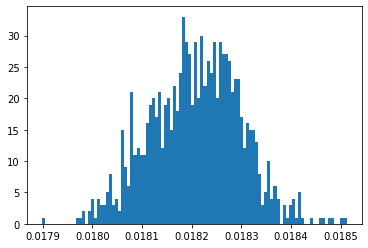

In [7]:
plt.hist(mean_deltas, bins=100)
plt.show()

In [8]:
print(f"Mean delta likelihood: {np.mean(mean_deltas)}")
print(f"Delta variance likelihood: {np.std(mean_deltas)}")

Mean delta likelihood: 0.018208811134683388
Delta variance likelihood: 9.030969385111089e-05


## Bump and Revalue

$$ \delta = \frac{V(S + \epsilon) -  V(S)}{\epsilon} $$

In [9]:
# Parameters
T = 1
K = 99
S0 = stock_price =  100
r = 0.06
sigma = 0.2
e = epsilon = 0.0001
n_iter = 1000

In [10]:
# Set common seed
seed = np.random.seed(69)

In [18]:
@njit
def digital_option_bumped(S0, K ,r, sigma, T, n_iter, epsilon):
    ''' Adjust digital option pricing for a bumped stock price'''
    mc_payoffs = []
    for i in range(n_iter):
        # Calculating the Stock price at T
        phi = np.random.standard_normal()
        ST = (S0+epsilon) * np.exp((r - 0.5 * sigma ** 2 ) * T + sigma * np.sqrt(T) * phi)

        # Check if digital option pays off
        if ST-K > 0:
            mc_payoffs.append( 1 * np.exp(-r)) # Present value of 1 euro
        else:
            mc_payoffs.append(0) # or present value of nothing

    # Returns a series of simulated prsent value digital option payoffs
    return mc_payoffs

# test = digital_option_bumped(S0, K ,r ,sigma ,T ,n_iter, epsilon)

In [19]:
@njit
def euler_digital_valuation(n_iter, epsilon):
    # All the valuations of the digital option (itself a mean of simulated paths)
    all_digital_valuations = []
    for i in range(n_iter):
        # Realised payoffs in n_iter simulated paths 
        payoffs = digital_option_bumped(S0, K ,r, sigma ,T ,n_iter, epsilon)
        all_digital_valuations.append(np.mean(np.array(payoffs))) # If i don't castthe list of results to an array it won't work!!
    
    return all_digital_valuations

In [20]:
@njit
def digital_delta_bumped(n_iter, epsilon,same_seed=True):
    if same_seed:
        bumped_values = euler_digital_valuation(n_iter, epsilon=epsilon)
        unbumped_values = euler_digital_valuation(n_iter, epsilon=0)
    else:
        pass
    delta =  (np.mean(np.array(bumped_values)) - np.mean(np.array(unbumped_values))) / epsilon
    return delta

test = digital_delta_bumped(1000, epsilon=0.01)
test

0.048877579293027384

As epsilon goes to zero the delta goes to zero as well, in order to get a positive value epsilon needs to be set a bit higher. See "Results digital call" in the slides for MCII

In [15]:
print(f"Mean delta likelihood: {np.mean(mean_deltas)}")
print(f"Delta variance likelihood: {np.std(mean_deltas)}")

Mean delta likelihood: 0.37670581343399745
Delta variance likelihood: 1.1102230246251565e-16


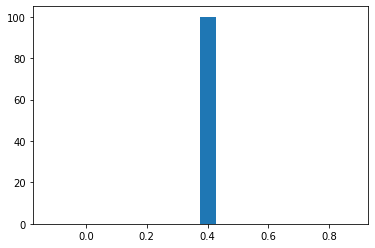

In [16]:
plt.hist(mean_deltas, bins=20)
plt.show()